# Evaluation

The evaluation strategy is as follows. There are 30 classes of images in the RSICD dataset. We construct a synthetic set of captions that use the pattern "An arial photograph of a `class_type`" for each of the 30 classes. We feed each image and the synthetic captions into the model under evaluation, and get back predictions of the best caption associated with the image. We calculate the matches at k for various k=1, 3, 5, 10, and report them.

In [ ]:
!pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.9/494.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.6 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools


from PIL import Image
from transformers import CLIPProcessor, FlaxCLIPModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture

!unzip /content/drive/MyDrive/rscid-dataset-remotesensing.zip -d /content/data/

In [ ]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(
    project_name="RS-ZSL-UNIVPM",
    measure_power_secs=15,
    output_file="emissions-testing.csv",
    log_level="debug",
    save_to_file=True,
)

tracker.start()

[codecarbon WARNING @ 11:44:57] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 11:44:57] [setup] RAM Tracking...
[codecarbon INFO @ 11:44:57] [setup] GPU Tracking...
[codecarbon INFO @ 11:44:57] No GPU found.
[codecarbon INFO @ 11:44:57] [setup] CPU Tracking...
[codecarbon DEBUG @ 11:44:57] Not using PowerGadget, an exception occurred while instantiating IntelPowerGadget : Platform not supported by Intel Power Gadget
[codecarbon DEBUG @ 11:44:57] Not using the RAPL interface, an exception occurred while instantiating IntelRAPL : Intel RAPL files not found at /sys/class/powercap/intel-rapl on linux
[codecarbon DEBUG @ 11:44:57] Not using PowerMetrics, an exception occurred while instantiating Powermetrics : Platform not supported by Powermetrics
[codecarbon WARNING @ 11:44:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 11:44:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please co

In [ ]:

DATA_DIR = "/content/data/dataset/RSICD"

IMAGES_DIR = os.path.join(DATA_DIR, "RSICD_images")
CAPTIONS_FILE = os.path.join(DATA_DIR, "dataset_rsicd.json")

# EVAL_IMAGES_LIST = os.path.join(DATA_DIR, "eval_images.txt")
EVAL_IMAGES_LIST = "eval_images.txt"
EVAL_RESULTS = "eval_results.tsv"

### Data

The RSICD dataset is split into train, val, and test sets of 8734, 1094 and 1093 images with associated captions respectively.

We will use only the images with the class name in the image file name.

In [ ]:
image_filenames = os.listdir(IMAGES_DIR)
len(image_filenames)

10921

In [ ]:
image2captions = {}
with open(CAPTIONS_FILE, "r") as fcap:
    data = json.loads(fcap.read())
for image in data["images"]:
    if image["split"] == "test":
        filename = image["filename"]
        if filename.find("_") > 0:
            sentences = []
            for sentence in image["sentences"]:
                sentences.append(sentence["raw"])
            image2captions[filename] = sentences

len(image2captions)

1027

filename: airport_348.jpg
sentences: ['the airport is very large .', 'next to the airport is green grass .', 'next to the airport is green grass .', 'the airport is very large .', 'the airport is very large .']


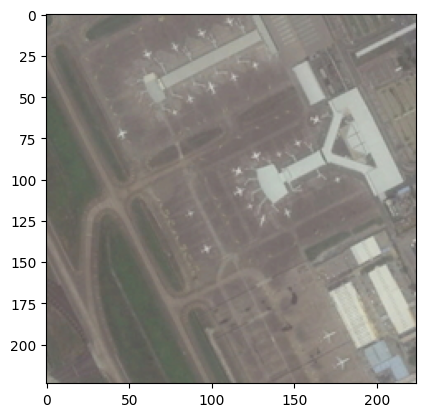

In [ ]:
for image_filename in image2captions.keys():
    print("filename:", image_filename)
    image = Image.fromarray(plt.imread(os.path.join(IMAGES_DIR, image_filename)))
    plt.imshow(image)
    print("sentences:", image2captions[image_filename])
    break

### Image Classes from file names

In [ ]:
class_types = sorted(list(set([fn.split("_")[0]
                               for fn in image_filenames
                               if fn.find("_") > -1])))
class_types

['airport',
 'bareland',
 'baseballfield',
 'beach',
 'bridge',
 'center',
 'church',
 'commercial',
 'denseresidential',
 'desert',
 'farmland',
 'forest',
 'industrial',
 'meadow',
 'mediumresidential',
 'mountain',
 'park',
 'parking',
 'playground',
 'pond',
 'port',
 'railwaystation',
 'resort',
 'river',
 'school',
 'sparseresidential',
 'square',
 'stadium',
 'storagetanks',
 'viaduct']

### Model

In [ ]:
model_name = 'CUSTOM'
model_path = '/content/drive/MyDrive/clip_tuned_model/CLIP_' + model_name

model = FlaxCLIPModel.from_pretrained(model_path)

#model = FlaxCLIPModel.from_pretrained("flax-community/clip-rsicd-v2")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
image_filename = list(image2captions.keys())[0]
sentences = image2captions[image_filename]

print("image file name:", image_filename)
print("sentences:", sentences)

image file name: airport_348.jpg
sentences: ['the airport is very large .', 'next to the airport is green grass .', 'next to the airport is green grass .', 'the airport is very large .', 'the airport is very large .']


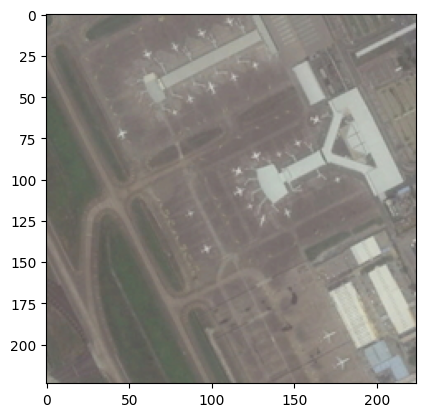

In [ ]:
test_image = Image.fromarray(plt.imread(os.path.join(IMAGES_DIR, image_filename)))
plt.imshow(test_image)

In [ ]:
test_sentences = ["An aerial photograph of a {:s}".format(ct) for ct in class_types]

In [ ]:
inputs = processor(text=test_sentences,
                   images=test_image, return_tensors="jax", padding=True)
outputs = model(**inputs)

In [ ]:
logits_per_image = outputs.logits_per_image
probs = jax.nn.softmax(logits_per_image, axis=-1)
probs

Array([[7.5454378e-01, 5.4310311e-02, 2.9866415e-04, 2.9792677e-04,
        4.2513107e-06, 4.4465065e-02, 1.7090818e-04, 3.7809346e-02,
        1.0130311e-02, 6.2651010e-03, 2.6316191e-03, 1.8181260e-03,
        2.0718947e-03, 1.3254975e-02, 5.2847578e-03, 3.0698515e-03,
        6.8104957e-05, 3.9421860e-04, 1.0800411e-03, 6.7211922e-06,
        7.0216200e-05, 5.1414156e-03, 3.4318923e-03, 1.7031120e-06,
        2.7828114e-03, 9.4141839e-03, 7.5453152e-03, 1.4903551e-04,
        3.3454891e-02, 3.2587239e-05]], dtype=float32)

In [ ]:
class_types[np.argmax(probs)]

'airport'

In [ ]:
probs_np = np.asarray(probs)[0]
probs_npi = np.argsort(-probs_np)
[(class_types[i], probs_np[i]) for i in probs_npi[0:5]]

[('airport', 0.7545438),
 ('bareland', 0.05431031),
 ('center', 0.044465065),
 ('commercial', 0.037809346),
 ('storagetanks', 0.03345489)]

### Putting everything together

label: baseballfield
predictions
park                 0.567
playground           0.149
square               0.078
meadow               0.042
center               0.029
school               0.015
bareland             0.015
farmland             0.015
storagetanks         0.013
resort               0.012


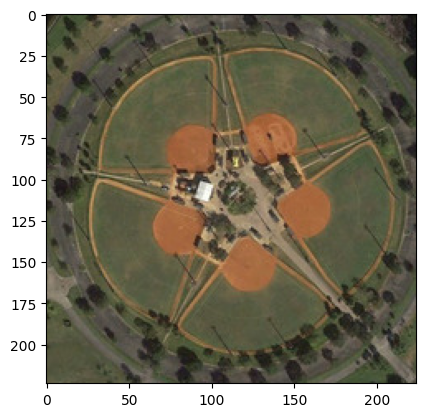

In [ ]:
def predict_one_image(image_file, model, processor, class_types, k):
    label = image_file.split('_')[0]
    test_sentences = ["An aerial photograph of a {:s}".format(ct) for ct in class_types]
    image = Image.fromarray(plt.imread(os.path.join(IMAGES_DIR, image_file)))
    inputs = processor(text=test_sentences,
                       images=image,
                       return_tensors="jax",
                       padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = jax.nn.softmax(logits_per_image, axis=-1)
    probs_np = np.asarray(probs)[0]
    probs_npi = np.argsort(-probs_np)
    predictions = [(class_types[i], probs_np[i]) for i in probs_npi[0:k]]
    return label, predictions


test_image = list(image2captions.keys())[100]
label, preds = predict_one_image(test_image, model, processor, class_types, 10)

image = Image.fromarray(plt.imread(os.path.join(IMAGES_DIR, test_image)))
plt.imshow(image)

print("label:", label)
print("predictions")
for class_type, class_prob in preds:
    print("{:20s} {:.3f}".format(class_type, class_prob))

In [ ]:
num_predicted = 0
fres = open(EVAL_RESULTS, "w")
for image_file, _ in image2captions.items():
    if num_predicted % 100 == 0:
        print("{:d} images processed".format(num_predicted))
#     print("predicting class of image:", image_file)
    label, preds = predict_one_image(image_file, model, processor, class_types, 10)
    fres.write("{:s}\t{:s}\t{:s}\n".format(
        image_file, label, "\t".join(["{:s}\t{:.5f}".format(c, p) for c, p in preds])))
    num_predicted += 1

print("{:d} images processed, COMPLETE".format(num_predicted))
fres.close()

0 images processed
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1027 images processed, COMPLETE


### Generate accuracy@k Scores from results

In [ ]:
RESULTS_DIR = "results"
RESULTS_FILE = os.path.join(RESULTS_DIR, "baseline.tsv")
K_VALUES = [1, 3, 5, 10]

In [ ]:
RESULTS_FILE = "eval_results.tsv"

num_examples = 0
correct_k = [0] * len(K_VALUES)

top_preds = []
ground_truth = []

fres = open(RESULTS_FILE, "r")
for line in fres:
    cols = line.strip().split('\t')
    label = cols[1]
    preds = []
    for i in range(2, 22, 2):
        preds.append(cols[i])
    for kid, k in enumerate(K_VALUES):
        preds_k = set(preds[0:k])
        if label in preds_k:
            correct_k[kid] += 1
    num_examples += 1
    top = preds[0]

    ground_truth.append(label)
    top_preds.append(top)

fres.close()
scores_k = [ck / num_examples for ck in correct_k]
print("\t".join(["score@{:d}".format(k) for k in K_VALUES]))
print("\t".join(["{:.3f}".format(s) for s in scores_k]))

score@1	score@3	score@5	score@10
0.603	0.763	0.848	0.959


In [ ]:
tracker.stop()

[codecarbon WARNING @ 13:56:56] Tracker already stopped !
[codecarbon WARNING @ 13:56:56] Background scheduler didn't run for a long period (3728s), results might be inaccurate
[codecarbon INFO @ 13:56:56] Energy consumed for RAM : 0.010450 kWh. RAM Power : 4.753040313720703 W
[codecarbon DEBUG @ 13:56:56] RAM : 4.75 W during 3,728.15 s [measurement time: 0.0039]
[codecarbon INFO @ 13:56:56] Energy consumed for all CPUs : 0.093455 kWh. Total CPU Power : 42.5 W
[codecarbon DEBUG @ 13:56:56] CPU : 42.50 W during 3,728.16 s [measurement time: 0.0015]
[codecarbon INFO @ 13:56:56] 0.103904 kWh of electricity used since the beginning.
[codecarbon DEBUG @ 13:56:56] last_duration=3728.1528236865997
------------------------
[codecarbon DEBUG @ 13:56:56] EmissionsData(timestamp='2024-06-19T13:56:56', project_name='RS-ZSL-UNIVPM', run_id='e0784cef-be6f-4ce1-a13a-c1b5e56b6991', duration=7918.038643836975, emissions=0.022706692556301592, emissions_rate=2.8677168144380557e-06, cpu_power=42.5, gpu_po

0.022706692556301592

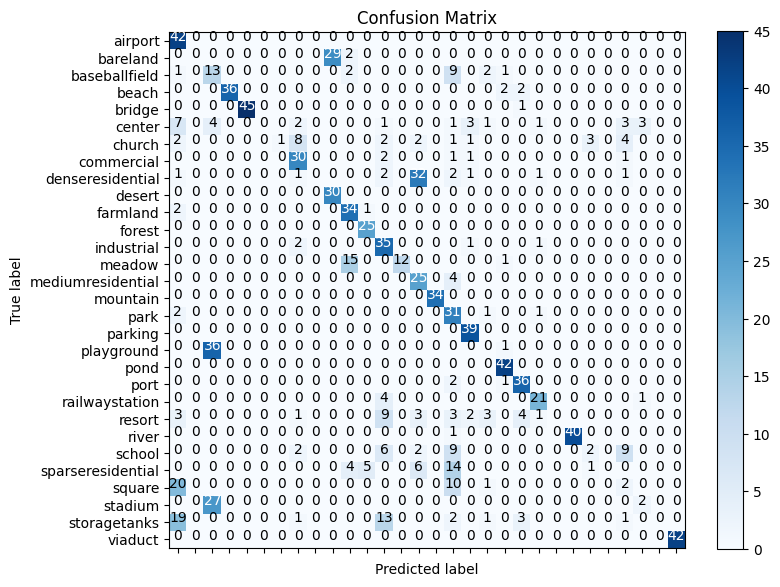

In [ ]:
# Confusion matrix

ground_truth = np.array(ground_truth)
top_preds = np.array(top_preds)

# Compute the confusion matrix
conf_matrix = confusion_matrix(ground_truth, top_preds)

labels = np.unique(ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, ['' for _ in range(len(labels))])  # Empty labels for x-axis
plt.yticks(tick_marks, labels)

# Display values in each cell
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()